In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from IPython.display import display

%matplotlib inline

In [ ]:
NONLINEAR = False

# Временные характеристики

## ПД-регулятор

In [ ]:
dt = 0.1
t_fin = 16

t = np.arange(0, t_fin+dt, dt)

N = t.shape[0]

In [ ]:
u = np.ones(N)
K, T = 5, 0.01

In [ ]:
def control_system(kp=1, kd=1, flc=None):
    s = pd.DataFrame(
        columns=['u', 'e', 'p', 'd', 'x', 'o', 'y'],
        index=[-2, -1]
    ).fillna(0)
    
    p = pd.DataFrame(
        columns=['sigma', 'delta', 't_first', 't_reg'],
        index=['']
    )
    
    t_first, t_reg = t_fin, t_fin
    for k in range(N):
        s.loc[k, 'u'] = 1.
        s.loc[k, 'e'] = s.loc[k, 'u'] - s.loc[k-1, 'y']
        s.loc[k, 'p'] = (s.loc[k, 'e'] * dt + s.loc[k-1, 'p'] * T) / (dt + T)
        s.loc[k, 'd'] = (s.loc[k, 'e'] - s.loc[k-1, 'e'] + s.loc[k-1, 'd'] * T) / (dt + T)
        if NONLINEAR:
            s.loc[k, 'd'] = np.sign(s.loc[k, 'd'])
        if flc:
            s.loc[k, 'x'] = flc.predict(s[['p', 'd']].loc[k])
        else:
            s.loc[k, 'x'] = kp * s.loc[k, 'p'] + kd * s.loc[k, 'd']
        s.loc[k, 'o'] = K * dt * s.loc[k, 'x'] + s.loc[k-1, 'o']
        s.loc[k, 'y'] = (s.loc[k, 'o'] * dt ** 2 - s.loc[k-2, 'y'] + s.loc[k-1, 'y'] * 2 * (dt + 1)) / (dt + 1) ** 2
        
        if 0.95 <= s.loc[k, 'y'] <= 1.05 and t_first == t_fin:
            t_first = t[k]

        if 0.95 <= s.loc[k, 'y'] <= 1.05 and t_reg == t_fin:
            t_reg = t[k]
        if t_reg != t_fin and not 0.95 <= s.loc[k, 'y'] <= 1.05:
            t_reg = t_fin

    s.drop([-2, -1], inplace=True)    
    
    sigma = np.round(s.y.max() - 1, 2) * 100
    sigma = max(0, int(sigma))

    delta = abs(np.round(s.y.iloc[-1] - 1, 3))
    
    p['sigma'] = sigma
    p['delta'] = delta
    p['t_first'] = t_first
    p['t_reg'] = t_reg
    
    if flc:
        thetas = np.array([1, 1.1]) * 0.1 * t_fin / 2
        m = [0, 0]

        for k1 in (0, 1):
            ksi = np.exp(-t[t <= t_fin / 2] / thetas[k1])
            ksi_prod_y = s.y[t <= t_fin / 2] * ksi

            S_y = 0
            for k2 in range(sum(t <= t_fin / 2) - 1):
                S_y += (ksi_prod_y[k2] + ksi_prod_y[k2+1]) * dt / 2

            v = 1. / thetas[k1]
            m[k1] = S_y * (1 + T * v) * (v * (1 + v)) ** 2 / (K - K * S_y * v)

        kd_est = (m[0] - m[1]) / ((1/thetas[0]) - (1/thetas[1]))
        kp_est = m[0] - kd_est / thetas[0]
        
        s_pd_est, _ = control_system(kp=kd_est, kd=kp_est)
        mse = mean_squared_error(s.y, s_pd_est.y)
        s['pd'] = s_pd_est.y
        
        p['kp'] = kp_est
        p['kd'] = kd_est
        p['mse'] = mse
        p['kd/kp'] = kd_est/kp_est
        p['20lg(kp)'] = 20 * np.log10(kp_est)
    
    return s, p

In [ ]:
s_pd, p_pd = control_system(kp=1, kd=1)

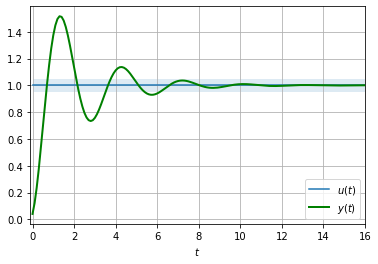

,sigma,delta,t_first,t_reg
,52,0.001,0.7,6.2


In [ ]:
plt.fill_between(t, 0.95 * s_pd.u, 1.05 * s_pd.u, alpha=0.15)
plt.plot(t, s_pd.u, label='$u(t)$')
plt.plot(t, s_pd.y, lw=2, label='$y(t)$', c='g')

plt.legend(loc='lower right')
plt.xlim([t[0]-0.1115, t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

display(p_pd)

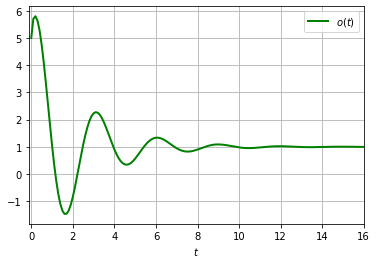

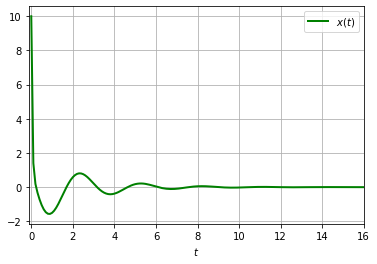

In [ ]:
for v in ('o', 'x'):
    eval(f"plt.plot(t, s_pd.{v}, lw=2, label='${v}(t)$', c='g')")
    plt.legend(loc='upper right')
    plt.xlim([t[0]-0.1115, t[-1]])
    plt.xlabel('$t$')
    plt.grid(True)
    plt.show()

## Нечеткий регулятор

In [ ]:
def mf_left(v, gamma=1, t=(-1, 0)):
    assert t[0] < t[1], 'Проверить термы!'
    if v < t[0]:
        return 1.
    elif v > t[1]:
        return 0.
    else:
        return abs( ((v - t[1]) / (t[0] - t[1])) ** gamma )
    
def mf_centre(v, gamma_left=1, gamma_right=1, t=(-1, 0, 0, 1)):
    assert t[0] < t[1] <= t[2] < t[3], 'Проверить термы!'
    if v < t[0] or v > t[3]:
        return 0.
    elif t[0] <= v <= t[1]:
        return abs( ((v - t[0]) / (t[1] - t[0])) ** gamma_left  )       
    elif t[2] <= v <= t[3]:
        return abs( ((v - t[3]) / (t[2] - t[3])) ** gamma_right  )    
    else:
        return 1.
    
def mf_right(v, gamma=1, t=(0, 1)):
    assert t[0] < t[1], 'Проверить термы!'    
    if v > t[1]:
        return 1.
    elif v < t[0]:
        return 0.
    else:        
        return abs( ((v - t[0]) / (t[1] - t[0])) ** gamma )

In [ ]:
R1 = [
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0]
]

R2 = [
    [0.8, 0.2, 0.0],
    [0.5, 0.5, 0.0],
    [0.4, 0.6, 0.4],
    [0.5, 0.5, 0.0],
    [0.3, 0.7, 0.3],
    [0.0, 0.5, 0.5],
    [0.4, 0.6, 0.4],
    [0.0, 0.5, 0.5],
    [0.0, 0.2, 0.8]
]

R3 = [
    [1.0, 0.0, 0.0],
    [0.7, 0.3, 0.0],
    [0.2, 0.8, 0.2],
    [0.3, 0.7, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.7, 0.3],
    [0.2, 0.8, 0.2],
    [0.0, 0.3, 0.7],
    [0.0, 0.0, 1.0]
]

In [ ]:
def _relational_matrix(R, input_names=None, output_name=None): # в FuzzyPDController
    index = pd.MultiIndex.from_product([['-1', '0', '1'], ['-1', '0', '1']], names=input_names)
    return pd.DataFrame(R, columns=['-1', '0', '1'], index=index).rename_axis(output_name, axis=1)

_relational_matrix(R3, ['p', 'd'], 'x')

x       -1    0    1
p  d                
-1 -1  1.0  0.0  0.0
   0   0.7  0.3  0.0
   1   0.2  0.8  0.2
0  -1  0.3  0.7  0.0
   0   0.0  1.0  0.0
   1   0.0  0.7  0.3
1  -1  0.2  0.8  0.2
   0   0.0  0.3  0.7
   1   0.0  0.0  1.0

In [ ]:
_logic_basis = {
    'максминный': 1 / 1e12, # 0
    'алгебраический': 1 - 1e-12, # 1
    'ограниченный': 1e12 - 1 # ∞
}

In [ ]:
def _frank_formula(l, a, b, operation='И'):
    if operation == 'И':
        # свойство оснований логарифма
        return np.log(1 + (l ** a - 1) * (l ** b - 1) / (l - 1)) / np.log(l)
    else:
        return 1 - _frank_formula(l, 1-a, 1-b)

In [ ]:
fuzzy_p = {'-1': lambda v: mf_left(v, t=(-1, 0)),
            '0': lambda v: mf_centre(v, t=(-1, 0, 0, 1)),
            '1': lambda v: mf_right(v, t=(0, 1))}

fuzzy_d = {'-1': lambda v: mf_left(v, t=(-1, 0)),
            '0': lambda v: mf_centre(v, t=(-1, 0, 0, 1)),
            '1': lambda v: mf_right(v, t=(0, 1))}

fuzzy_x = {'-1': lambda v: mf_left(v, t=(-1, 0)),
            '0': lambda v: mf_centre(v, t=(-1, 0, 0, 1)),
            '1': lambda v: mf_right(v, t=(0, 1))}

TERMS = ['-1', '0', '1']

In [ ]:
class FuzzyPDController:
    
    def __init__(self, fuzzy_i1, fuzzy_i2, fuzzy_x, R, logic_basis='максминный', b=[1, 1], def_type='cog'):
        self.fuzzy_i1 = fuzzy_i1
        self.fuzzy_i2 = fuzzy_i2
        self.fuzzy_x = fuzzy_x
        self.R = _relational_matrix(R, input_names=['i1', 'i2'], output_name='x')
        self.l = _logic_basis[logic_basis]
        self.b = b
        self.def_type = def_type
        self.dx = 0.002 # 0.002
        self.x_space = pd.DataFrame(np.arange(-1, 1+self.dx, self.dx), columns=['x'])
        
    
    def predict(self, inputs):
        i1, i2 = inputs        
        interference = self.R.reset_index()
        
        # фаззификация
        
        interference['i1'] = interference['i1'].apply(
            lambda v: 1 - self.b[0] * (1 - self.fuzzy_i1[v](i1))
        )
        interference['i2'] = interference['i2'].apply(
            lambda v: 1 - self.b[1] * (1 - self.fuzzy_i2[v](i2))
        )
        
        # активация
        
        interference['_act'] = interference[['i1', 'i2']].apply(
            lambda v: _frank_formula(self.l, v.i1, v.i2), axis=1
        )
        
        for term in TERMS: # self.fuzzy_o.keys()
            interference[term] = interference[[term, '_act']].apply(
                lambda v: _frank_formula(self.l, v[term], v._act), axis=1
            )
        
        # аккумуляция
        
        accumulation = [0, 0, 0]
        for k1 in range(3): # len(self.fuzzy_o.keys())
            accumulation[k1] = _frank_formula(
                self.l,
                interference.loc[0, TERMS[k1]],
                interference.loc[1, TERMS[k1]],
                operation='ИЛИ'
            )
            for k2 in range(2, 9): # len(fuzzy_i1.keys()) * len(fuzzy_i2.keys())
                accumulation[k1] = _frank_formula(
                    self.l,
                    interference.loc[k2, TERMS[k1]],
                    accumulation[k1],
                    operation='ИЛИ'
                )
        accumulation = pd.Series(accumulation, index=TERMS) # self.fuzzy_x.keys()
        
        # дефаззификация
        
        if np.max(accumulation) == 0:
            return 0
        
        for term in TERMS:  # self.fuzzy_o.keys()
            self.x_space[term] = self.x_space['x'].apply(
                lambda x: min(self.fuzzy_x[term](x), accumulation[term])
            )
            
        self.x_space['_dfz'] = self.x_space[TERMS].max(axis=1)  # self.fuzzy_x.keys()
        
        if self.def_type == 'coa':
            i, s = 0, 0
            s_half = self.x_space._dfz.sum() * self.dx / 2
            while s <= s_half:
                s += self.x_space._dfz[i] * self.dx
                i += 1
            if s > s_half:
                x = (self.x_space.x[i] + self.x_space.x[i-1]) / 2
            else:
                x = self.x_space.x[i]
        else:
            x = np.sum(self.x_space._dfz * self.x_space.x) / np.sum(self.x_space._dfz)
        
        return x

In [ ]:
flc_R1 = FuzzyPDController(fuzzy_p, fuzzy_d, fuzzy_x, R1, def_type='cog')
flc_R2 = FuzzyPDController(fuzzy_p, fuzzy_d, fuzzy_x, R2, def_type='cog')
flc_R3 = FuzzyPDController(fuzzy_p, fuzzy_d, fuzzy_x, R3, def_type='cog')

In [ ]:
s_R1, p_R1 = control_system(flc=flc_R1)
s_R2, p_R2 = control_system(flc=flc_R2)
s_R3, p_R3 = control_system(flc=flc_R3)

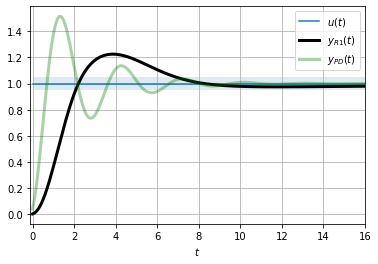

,,sigma,delta,t_first,t_reg
PD,,52,0.001,0.7,6.2
R1,,23,0.020,2.1,6.9


In [ ]:
plt.fill_between(t, 0.95 * s_pd.u, 1.05 * s_pd.u, alpha=0.15)
plt.plot(t, s_R1.u, label='$u(t)$')
plt.plot(t, s_R1.y, lw=3, label='$y_{R1}(t)$', c='k')
plt.plot(t, s_pd.y, lw=3, label='$y_{PD}(t)$', c='g', alpha=0.35)

plt.legend(loc='best')
plt.xlim([t[0]-0.1115, t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

display(pd.concat([p_pd, p_R1[p_pd.columns]], keys=['PD', 'R1']))

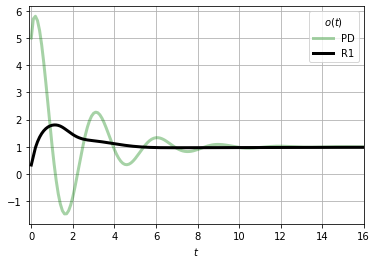

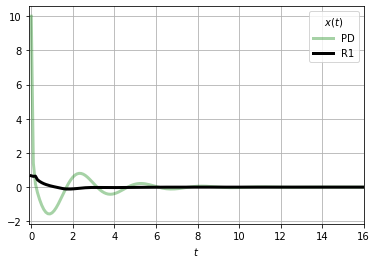

In [ ]:
for v in ('o', 'x'):
    eval(f"plt.plot(t, s_pd.{v}, lw=3, label='PD', c='g', alpha=0.35)")
    eval(f"plt.plot(t, s_R1.{v}, lw=3, label='R1', c='k')")
    plt.legend(title=f'${v}(t)$', loc='upper right')
    plt.xlim([t[0]-0.1115, t[-1]])
    plt.xlabel('$t$')
    plt.grid(True)
    plt.show()

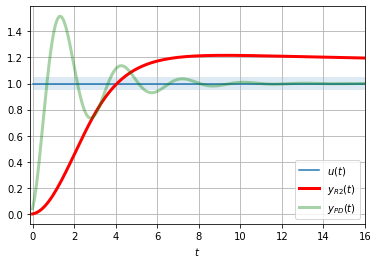

,,sigma,delta,t_first,t_reg
PD,,52,0.001,0.7,6.2
R2,,22,0.195,3.8,16.0


In [ ]:
plt.fill_between(t, 0.95 * s_pd.u, 1.05 * s_pd.u, alpha=0.15)
plt.plot(t, s_R2.u, label='$u(t)$')
plt.plot(t, s_R2.y, lw=3, label='$y_{R2}(t)$', c='r')
plt.plot(t, s_pd.y, lw=3, label='$y_{PD}(t)$', c='g', alpha=0.35)

plt.legend(loc='best')
plt.xlim([t[0]-0.1115, t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

display(pd.concat([p_pd, p_R2[p_pd.columns]], keys=['PD', 'R2']))

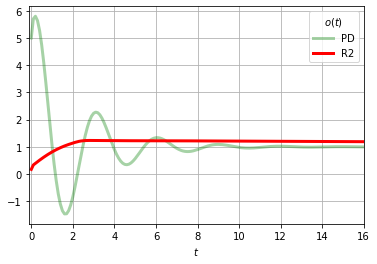

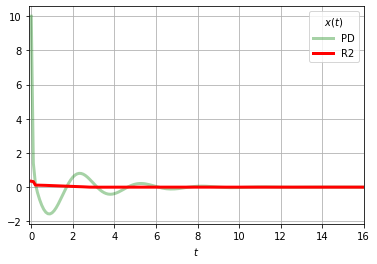

In [ ]:
for v in ('o', 'x'):
    eval(f"plt.plot(t, s_pd.{v}, lw=3, label='PD', c='g', alpha=0.35)")
    eval(f"plt.plot(t, s_R2.{v}, lw=3, label='R2', c='r')")
    plt.legend(title=f'${v}(t)$', loc='upper right')
    plt.xlim([t[0]-0.1115, t[-1]])
    plt.xlabel('$t$')
    plt.grid(True)
    plt.show()

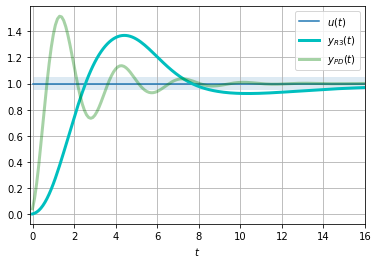

,,sigma,delta,t_first,t_reg
PD,,52,0.001,0.7,6.2
R3,,37,0.030,2.5,13.6


In [ ]:
plt.fill_between(t, 0.95 * s_pd.u, 1.05 * s_pd.u, alpha=0.15)
plt.plot(t, s_R3.u, label='$u(t)$')
plt.plot(t, s_R3.y, lw=3, label='$y_{R3}(t)$', c='c')
plt.plot(t, s_pd.y, lw=3, label='$y_{PD}(t)$', c='g', alpha=0.35)

plt.legend(loc='best')
plt.xlim([t[0]-0.1115, t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

display(pd.concat([p_pd, p_R3[p_pd.columns]], keys=['PD', 'R3']))

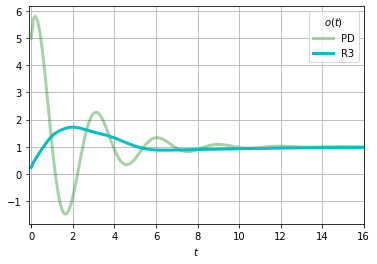

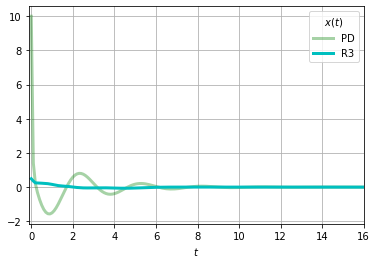

In [ ]:
for v in ('o', 'x'):
    eval(f"plt.plot(t, s_pd.{v}, lw=3, label='PD', c='g', alpha=0.35)")
    eval(f"plt.plot(t, s_R3.{v}, lw=3, label='R3', c='c')")
    plt.legend(title=f'${v}(t)$', loc='upper right')
    plt.xlim([t[0]-0.1115, t[-1]])
    plt.xlabel('$t$')
    plt.grid(True)
    plt.show()

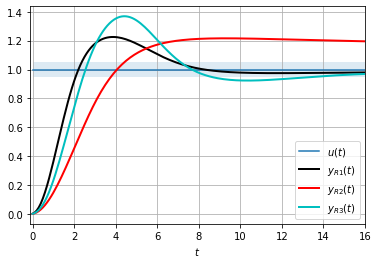

,,sigma,delta,t_first,t_reg,kp,kd,mse,kd/kp,20lg(kp)
R1,,23,0.020,2.1,6.9,0.232440,0.215756,0.004005,0.928224,-12.673785
R2,,22,0.195,3.8,16.0,0.105037,0.081463,0.031291,0.775569,-19.573164
R3,,37,0.030,2.5,13.6,0.213231,0.109482,0.028900,0.513443,-13.423000


In [ ]:
plt.fill_between(t, 0.95 * s_pd.u, 1.05 * s_pd.u, alpha=0.15)
plt.plot(t, s_pd.u, label='$u(t)$')
if NONLINEAR:
    plt.plot(t, s_pd.y, lw=3, label='$y_{PD}(t)$', c='g', alpha=0.35)
plt.plot(t, s_R1.y, lw=2, label='$y_{R1}(t)$', c='k')
plt.plot(t, s_R2.y, lw=2, label='$y_{R2}(t)$', c='r')
plt.plot(t, s_R3.y, lw=2, label='$y_{R3}(t)$', c='c')

plt.legend(loc='best')
plt.xlim([t[0]-0.1115, t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

display(pd.concat([p_R1, p_R2, p_R3], keys=['R1', 'R2', 'R3']))

# Частотные характеристики

In [ ]:
ws = np.concatenate([k * np.arange(1, 10, 0.2) for k in (0.1, 1, 10, 100)]) # 0.2

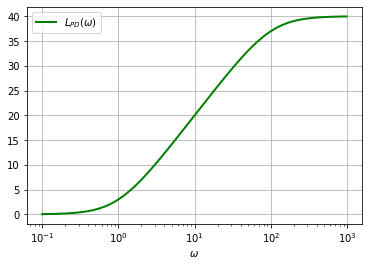

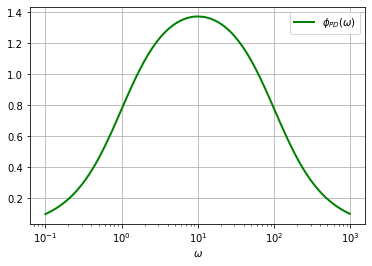

In [ ]:
L_pd = 20 * np.log10((1 + ws ** 2) ** 0.5) - 20 * np.log10((1 + (T * ws) ** 2) ** 0.5)
P_pd = np.arctan(ws) - np.arctan(ws * T)

plt.plot(ws, L_pd, lw=2, label='$L_{PD}(\omega)$', c='g')
plt.xscale('log')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.plot(ws, P_pd, lw=2, label='$\phi_{PD}(\omega)$', c='g')
plt.xscale('log')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
def period(w, flc, N=100):
    t_fin = 2 * np.pi / w
    t = np.linspace(0, t_fin, N)

    s = pd.DataFrame(
        columns=['t', 'e', 'p', 'd', 'x'],
        index=[-1]
    ).fillna(0)
    
    for k in range(N):
        s.loc[k, 't'] = t[k]
        s.loc[k, 'e'] = np.sin(w * s.loc[k, 't'])
        s.loc[k, 'p'] = (s.loc[k, 'e'] * t_fin / N + s.loc[k-1, 'p'] * T) / (t_fin/N + T)
        s.loc[k, 'd'] = (s.loc[k, 'e'] - s.loc[k-1, 'e'] + s.loc[k-1, 'd'] * T) / (t_fin/N + T)
        if NONLINEAR:
            s.loc[k, 'd'] = np.sign(s.loc[k, 'd'])
    
    s['x'] = s.apply(lambda v: flc.predict(v[['p', 'd']]), axis=1)
    
    return s

In [ ]:
def harmonic(x, i=1, N=100):
    Xp, Xq = 0., 0.
    for k in range(N):
        Xp += x[k] * np.sin(2 * np.pi * i * (k+1) / N)
        Xq += x[k] * np.cos(2 * np.pi * i * (k+1) / N)
    Xp *= 2 / N
    Xq *= 2 / N

    A = (Xp * Xp + Xq * Xq) ** 0.5
    P = np.arctan(Xq/Xp)
    L = 20 * np.log10(A)
    
    return A, P, L

In [ ]:
def frequency_characteristics(ws, flc):
    As, Ps, Ls = [], [], []

    for w in tqdm(ws):
        s = period(w, flc=flc)
        A1, P1, L1 = harmonic(s['x'], i=1)

        As.append(A1)
        Ps.append(P1)
        Ls.append(L1)
        
    return As, Ps, Ls

In [ ]:
A_R1, P_R1, L_R1 = frequency_characteristics(ws, flc_R1)

100%|██████████| 180/180 [06:50<00:00,  2.28s/it]


In [ ]:
A_R2, P_R2, L_R2 = frequency_characteristics(ws, flc_R2)

100%|██████████| 180/180 [06:49<00:00,  2.27s/it]


In [ ]:
A_R3, P_R3, L_R3 = frequency_characteristics(ws, flc_R3)

100%|██████████| 180/180 [07:13<00:00,  2.41s/it]


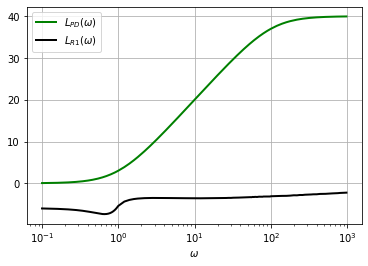

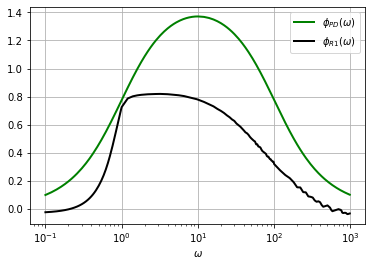

In [ ]:
plt.plot(ws, L_pd, lw=2, label='$L_{PD}(\omega)$', c='g')
plt.plot(ws, L_R1, lw=2, label='$L_{R1}(\omega)$', c='k')
plt.xscale('log')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.plot(ws, P_pd, lw=2, label='$\phi_{PD}(\omega)$', c='g')
plt.plot(ws, P_R1, lw=2, label='$\phi_{R1}(\omega)$', c='k')
plt.xscale('log')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

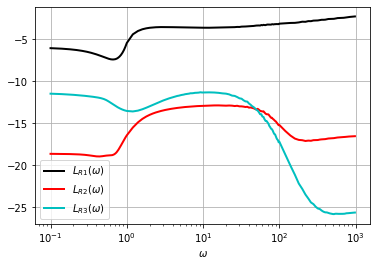

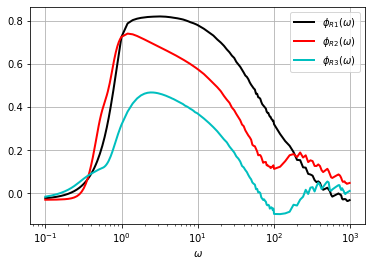

In [ ]:
plt.plot(ws, L_R1, lw=2, label='$L_{R1}(\omega)$', c='k')
plt.plot(ws, L_R2, lw=2, label='$L_{R2}(\omega)$', c='r')
plt.plot(ws, L_R3, lw=2, label='$L_{R3}(\omega)$', c='c')
plt.xscale('log')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.plot(ws, P_R1, lw=2, label='$\phi_{R1}(\omega)$', c='k')
plt.plot(ws, P_R2, lw=2, label='$\phi_{R2}(\omega)$', c='r')
plt.plot(ws, P_R3, lw=2, label='$\phi_{R3}(\omega)$', c='c')
plt.xscale('log')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Гармоники

In [ ]:
def show_p_and_h(flc):
    w_harm = (0.1, 1, 10, 100) if not NONLINEAR else (10, 20, 50, 100, 200, 500)
    for w in w_harm:

        s = period(w=w, flc=flc, nonlinear=NONLINEAR)

        fig = plt.figure(figsize=(13, 5))

        ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
        s[['t', 'p', 'd', 'x']].plot(x='t', lw=2, ax=ax1)
        ax1.grid(True)
        ax1.set_ylim([-1.11, 1.11])

        As, Ps = [], []
        hs = np.arange(1, 11)
        for i in hs:
            A, P, L = harmonic(s['x'], i=i)
            As.append(A)
            Ps.append(P)

        ax2 = plt.subplot2grid((2, 2), (0, 1))
        ax2.bar(hs, As, color='g')

        ax3 = plt.subplot2grid((2, 2), (1, 1))
        ax3.bar(hs, Ps, color='g')

        plt.suptitle(f'$\omega={w}$')
        plt.show()

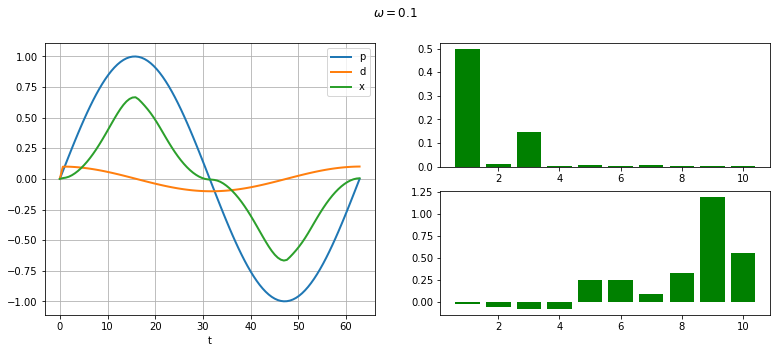

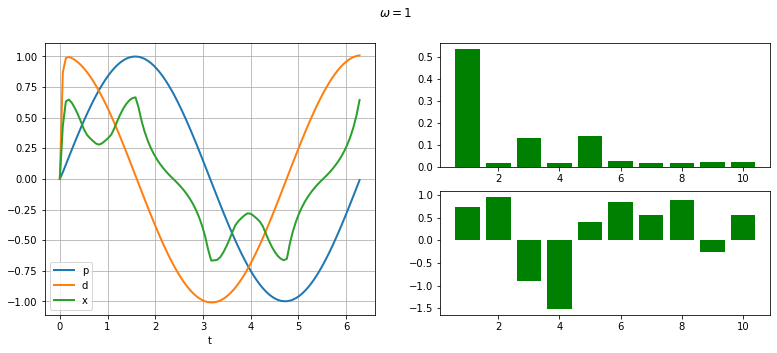

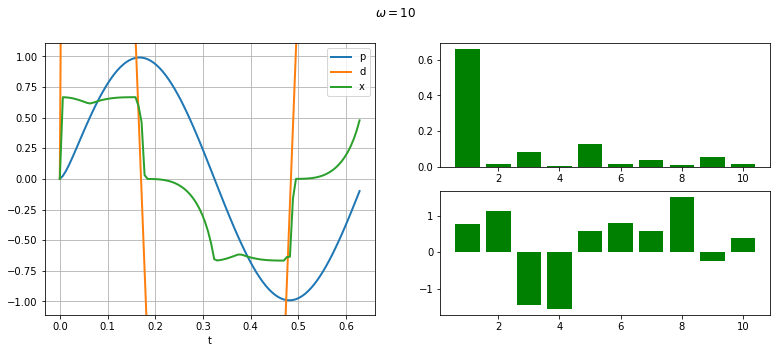

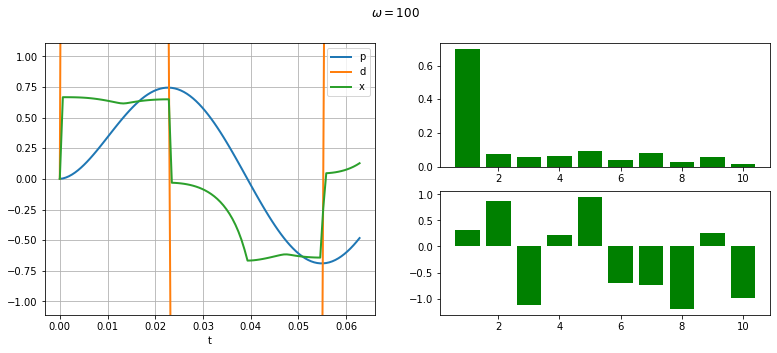

In [ ]:
show_p_and_h(flc_R1)

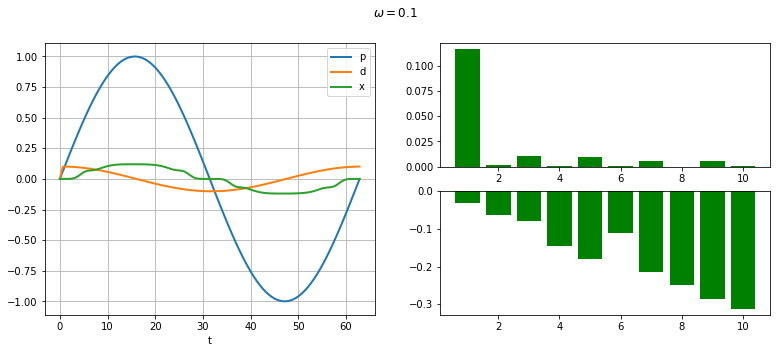

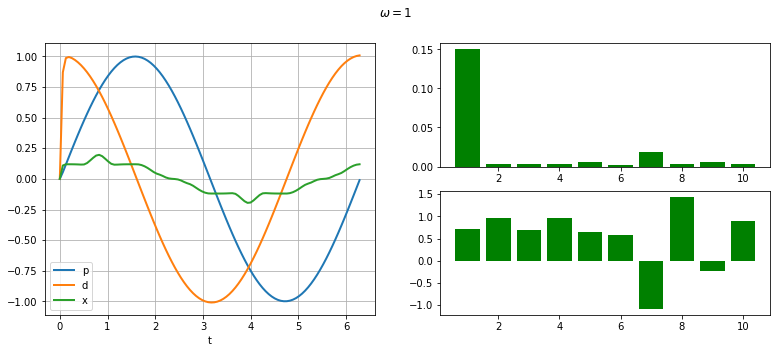

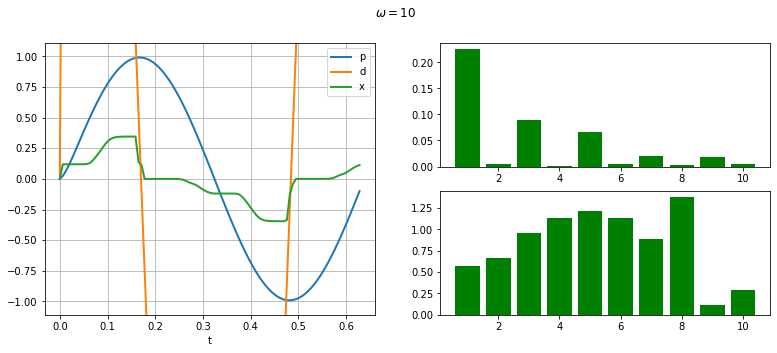

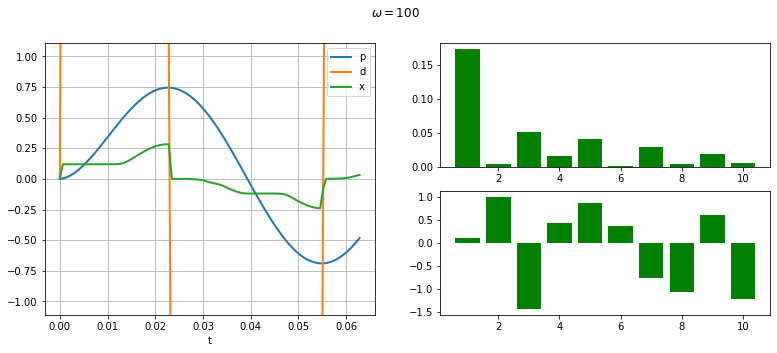

In [ ]:
show_p_and_h(flc_R2)

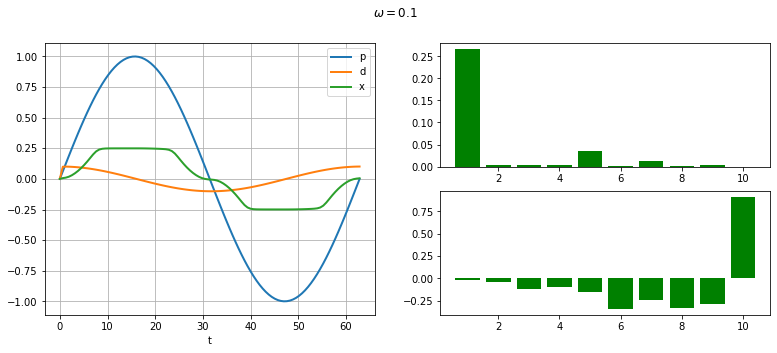

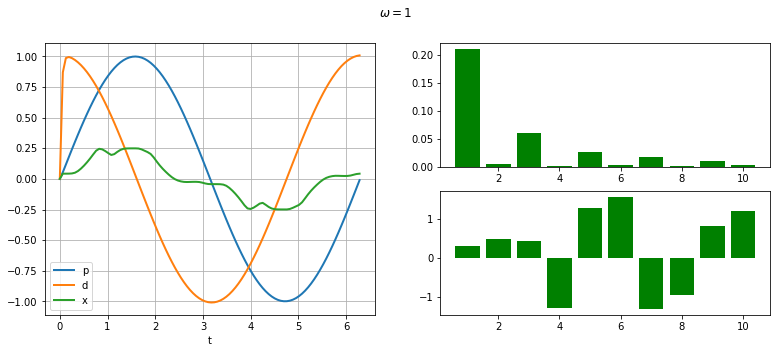

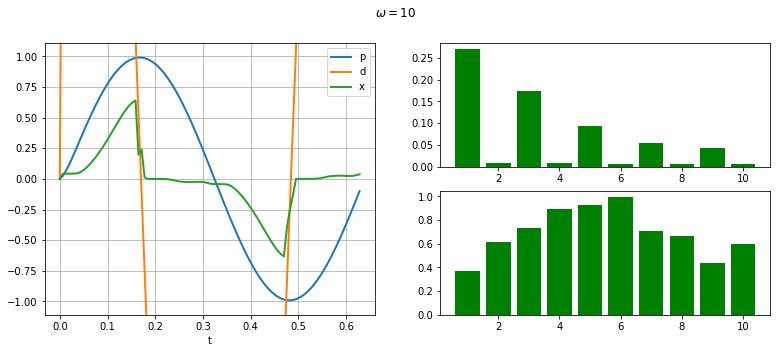

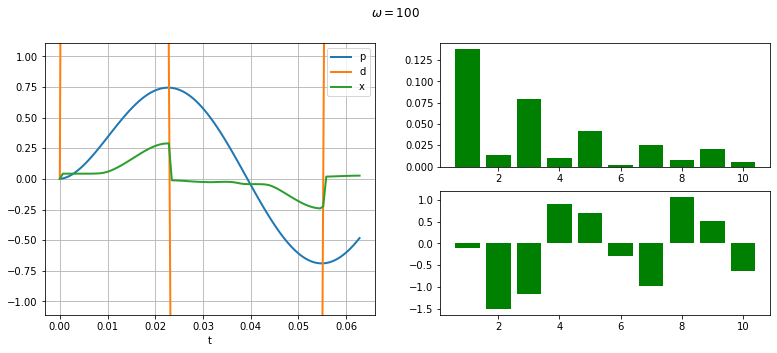

In [ ]:
show_p_and_h(flc_R3)